# Example Usage

This notebook shows how the extension can be used as part of a model training workflow.  To run this notebook, you must have:

- MarkLogic running in a Docker container `ml`.
- Ran `./gradlew mlDeploy` to configure MarkLogic.
- Ran `./gradlew loadSampleData` to load example data.

First, we need to load the extension using `%load_ext` and use `%marklogic_connect` to tell it how to connect to MarkLogic.

In [1]:
%load_ext marklogic_ext
%marklogic_connect http://admin:admin@ml:8010

Connection to http://ml:8010 OK


We can inspect the database by running some server-side Javascript code.  Placing `%%marklogic_sjs` indicates that the contents of the cell should be interpreted as Javascript and evaluated on the server.  With the `-dataframe` option, the extension will try to coerce the output into a `pandas.DataFrame`; if it can't, an error will be raised.

In [2]:
%%marklogic_sjs -dataframe

fn.collection("sample-data");

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,178,2013.083,33,181.0766,9,24.97697,121.54262,42
1,287,2012.917,5.9,90.45606,9,24.97433,121.5431,56.3
2,396,2012.917,21.2,512.5487,4,24.974,121.53842,42.5
3,135,2012.667,33.4,186.9686,6,24.96604,121.54211,42.2
4,244,2013.417,32.8,204.1705,8,24.98236,121.53923,48.2
...,...,...,...,...,...,...,...,...
409,12,2013.333,6.3,90.45606,9,24.97433,121.5431,58.1
410,192,2013.167,13.2,750.0704,2,24.97371,121.54951,37.8
411,80,2013.000,18,1414.837,1,24.95182,121.54887,26.5
412,219,2013.417,13.6,492.2313,5,24.96515,121.53737,43.8


The sample data are real estate price predictions downloaded from [Kaggle](https://www.kaggle.com/quantbruce/real-estate-price-prediction).  Conceptually, we would use MarkLogic as a data hub/data integration platform, wherein data would be cleaned, enriched, and perhaps even mastered, making it a good source for training datasets.

We'll use the data to create a model for predicting house prices.  For now, we'll run some more server-side Javascript to cherry-pick and format the data we need.

In [3]:
%%marklogic_sjs -dataframe

fn.collection("sample-data").toArray().map(doc => {
    const r = doc.toObject();
    return {
        x1: r["X1 transaction date"],
        x2: r["X2 house age"],
        x3: r["X3 distance to the nearest MRT station"],
        x4: r["X4 number of convenience stores"],
        y: r["Y house price of unit area"]
    };
});

,x1,x2,x3,x4,y
0,2013.083,33,181.0766,9,42
1,2012.917,5.9,90.45606,9,56.3
2,2012.917,21.2,512.5487,4,42.5
3,2012.667,33.4,186.9686,6,42.2
4,2013.417,32.8,204.1705,8,48.2
...,...,...,...,...,...
409,2013.333,6.3,90.45606,9,58.1
410,2013.167,13.2,750.0704,2,37.8
411,2013.000,18,1414.837,1,26.5
412,2013.417,13.6,492.2313,5,43.8


Now we have enough to create some training and test data.  In IPython/Jupyter, you can use _underscore_ to get the output of the previous cell, which in this case is a DataFrame constructed from an array of JSON objects.

In [4]:
from sklearn.model_selection import train_test_split

y = _["y"]
x = _.drop("y", axis = 1)

# split the data into training and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print('Samples for training: ' + str(len(x)))
print('Samples for testing: ' + str(len(x_test)))

Samples for training: 414
Samples for testing: 83


We then create and train a linear regression model.  There are many Python libraries for machine learning; in this instance we'll use the *sklearn* Python module.  

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# create a pipeline to normalize the inputs then calculate estimate
scaler = StandardScaler()
model = LinearRegression()

pl = Pipeline(steps = [
    ('scaler', scaler),
    ('estimator', model)
])

# train
pl.fit(x_train, y_train)

print('Intercept: ', model.intercept_)
print('Coefficients: ', model.coef_)

Intercept:  38.15256797583054
Coefficients:  [ 1.73690609 -2.9224841  -6.94223375  4.05634873]


Score: 0.48442752994554283


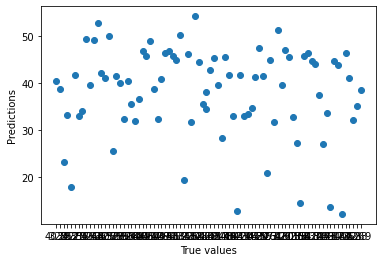

In [6]:
import matplotlib.pyplot as plt  

# run the model against the scaled test data
predicted_y = pl.predict(x_test)

# get the R2 score
score = pl.score(x_test, y_test)
print('Score: ' + str(score))

plt.scatter(y_test, predicted_y)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.show()

MarkLogic has the ability to execute ONNX models.  We can export our model to ONNX so we can execute it server-side, perhaps as part of a enrichment process or data hub step.

In [7]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

inputs = [
    ('x1', FloatTensorType([None, 1])),
    ('x2', FloatTensorType([None, 1])),
    ('x3', FloatTensorType([None, 1])),
    ('x4', FloatTensorType([None, 1]))
]
onnx = convert_sklearn(pl, 'pipeline', inputs)

We can then insert the ONNX model into MarkLogic as a binary document.  `%marklogic_doc_insert` lets you insert a document given a Python dict containing the document's `uri` and `content`.  The content can be a string or bytes (in this case, bytes).  We can optionally specify the `format` (can be `xml`, `json`, or `binary`) to explicitly specify the mime-type.

In [8]:
insert_model = {
    "uri": "/models/example.onnx",
    "format": "binary",
    "content": onnx.SerializeToString()
}
%marklogic_doc_insert insert_model

204 Content Updated /models/example.onnx


Now we can test the ONNX model out by running it server-side.

In [9]:
%%marklogic_sjs

const inputs = {
    x1: ort.value([2013.083], [1, 1], "FLOAT"),
    x2: ort.value([33], [1, 1], "FLOAT"),
    x3: ort.value([181.0766], [1, 1], "FLOAT"),
    x4: ort.value([9], [1, 1], "FLOAT")
};
const session = ort.session(cts.doc("/models/example.onnx"));
const outputs = ort.run(session, inputs);
const outputValue = ort.valueGetArray(outputs[ort.sessionOutputName(session, 0)])[0];

outputValue;

45.3390922546387